In [1]:
import os
import cv2
import numpy as np

dataset_path = "/home/basma/Plant_Disease/dataset_tomato/"
IMG_SIZE = 128


def preprocess_image(img, filter_type="none"):

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    if filter_type == "gaussian":
        img = cv2.GaussianBlur(img, (5, 5), 0)
    elif filter_type == "median":
        img = cv2.medianBlur(img, 5)

    img = img / 255.0 
    return img

def load_dataset(dataset_path, filter_type="none"):
    data = []
    labels = []

    classes = os.listdir(dataset_path)
    classes.sort() 

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_image(img, filter_type)
            data.append(img)
            labels.append(i)

    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    return data, labels, classes

# Test du preprocessing
filters = ["none", "gaussian", "median"]

for f in filters:
    print("\n==============================")
    print("Filter:", f)
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)
    print("Number of classes:", len(classes))
    print("Classes:", classes[:5])




Filter: none
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: gaussian
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']

Filter: median
Data shape: (4268, 128, 128, 3)
Labels shape: (4268,)
Number of classes: 5
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy']


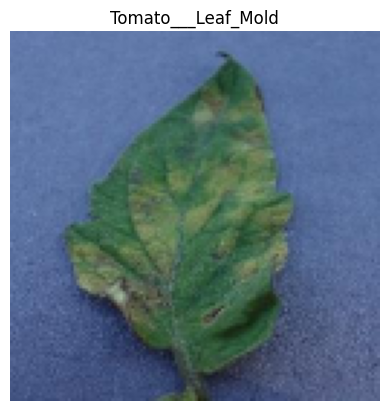

In [2]:
import matplotlib.pyplot as plt

data, labels, classes = load_dataset(dataset_path, filter_type="none")

index = 2232
plt.imshow(data[index])
plt.title(classes[labels[index]])
plt.axis("off")
plt.show()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# ===============================
# Construction du modèle CNN
# ===============================

EPOCHS = 10
BATCH_SIZE = 32

def build_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

2026-02-09 21:08:59.989622: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 21:09:00.005956: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 21:09:00.733682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 21:09:03.010765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [4]:

# ===============================
# Expériences avec filtres
# ===============================

results = {}

for f in filters:
    print("\n==============================")
    print("Training with filter:", f)
    # Charger dataset :
    data, labels, classes = load_dataset(dataset_path, filter_type=f)
    data, labels = shuffle(data, labels, random_state=42)

    # Split the data :
    X_train, X_temp, y_train, y_temp = train_test_split(
        data, labels, test_size=0.30, random_state=42)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42)
    
    model = build_model(len(classes))
    model.summary()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[f] = test_acc
    print(f"Test accuracy with {f}: {test_acc:.4f}")


Training with filter: none


/home/basma/Plant_Disease/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-09 21:09:19.280418: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.4684 - loss: 1.4054 - val_accuracy: 0.6484 - val_loss: 0.9703
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.7523 - loss: 0.6658 - val_accuracy: 0.7625 - val_loss: 0.6072
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.8400 - loss: 0.4422 - val_accuracy: 0.7953 - val_loss: 0.5299
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.8966 - loss: 0.3030 - val_accuracy: 0.8188 - val_loss: 0.5250
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.9170 - loss: 0.2359 - val_accuracy: 0.8203 - val_loss: 0.4918
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.9515 - loss: 0.1470 - val_accuracy: 0.8266 - val_loss: 0.5450
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9786 - loss: 0.0765 - val_accuracy: 0.8109 - val_loss: 0.7182
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.9920 - loss: 0.0372 - val_accu

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.5142 - loss: 1.2785 - val_accuracy: 0.6906 - val_loss: 0.8121
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.7811 - loss: 0.6022 - val_accuracy: 0.7812 - val_loss: 0.5757
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.8497 - loss: 0.4147 - val_accuracy: 0.7906 - val_loss: 0.5318
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8882 - loss: 0.3095 - val_accuracy: 0.8203 - val_loss: 0.4623
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.9237 - loss: 0.2162 - val_accuracy: 0.8234 - val_loss: 0.4841
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9528 - loss: 0.1463 - val_accuracy: 0.8234 - val_loss: 0.5355
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9602 - loss: 0.1204 - val_accuracy: 0.8062 - val_loss: 0.5373
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.9705 - loss: 0.0839 - val_accu

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.4972 - loss: 1.2705 - val_accuracy: 0.6672 - val_loss: 0.9333
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.7814 - loss: 0.5957 - val_accuracy: 0.7500 - val_loss: 0.6530
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.8681 - loss: 0.3671 - val_accuracy: 0.7781 - val_loss: 0.6301
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9089 - loss: 0.2564 - val_accuracy: 0.8281 - val_loss: 0.4970
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.9498 - loss: 0.1533 - val_accuracy: 0.8078 - val_loss: 0.5806
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.9746 - loss: 0.0871 - val_accuracy: 0.8281 - val_loss: 0.5645
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9893 - loss: 0.0480 - val_accuracy: 0.8422 - val_loss: 0.6436
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.9863 - loss: 0.0434 - val_accu

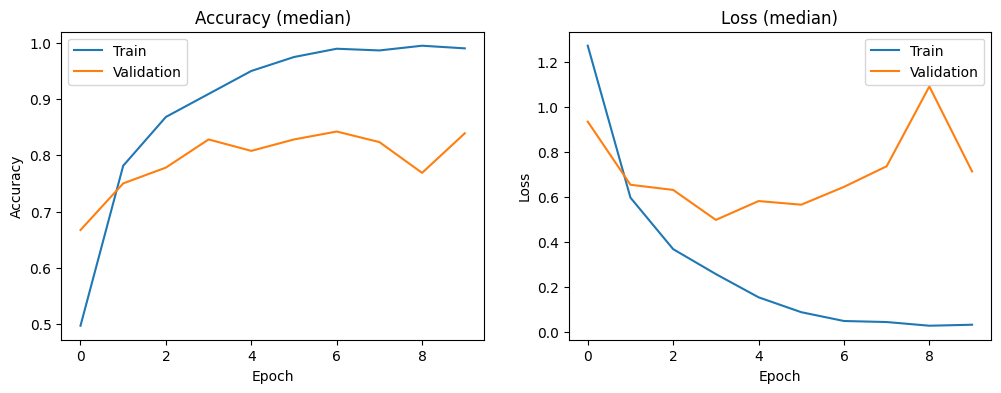

In [5]:

# ===============================
# Courbes Accuracy / Loss
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title(f'Accuracy ({f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title(f'Loss ({f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show() 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Classification Report:

                             precision    recall  f1-score   support

      Tomato___Early_blight       0.79      0.87      0.83       112
       Tomato___Late_blight       0.87      0.73      0.80       132
         Tomato___Leaf_Mold       0.79      0.90      0.84       135
Tomato___Septoria_leaf_spot       0.86      0.83      0.85       135
           Tomato___healthy       0.99      0.96      0.98       127

                   accuracy                           0.86       641
                  macro avg       0.86      0.86      0.86       641
               weighted avg       0.86      0.86      0.86       641



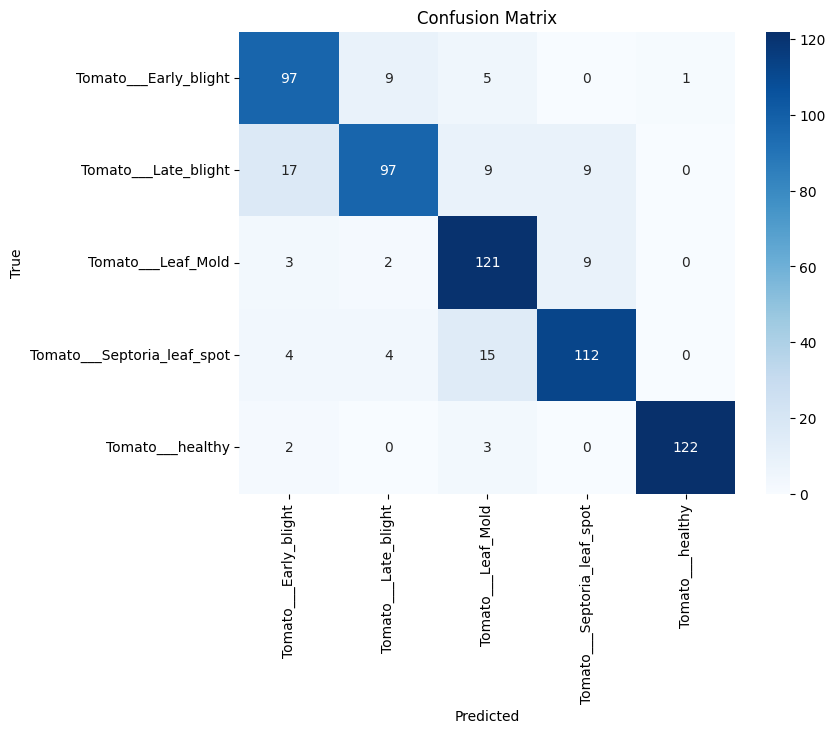

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = y_test
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes))
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [7]:
import pandas as pd

df_results = pd.DataFrame({
    "Filter": list(results.keys()),
    "Test Accuracy": list(results.values())
})

print("\nTableau comparatif des méthodes de filtrage :")
display(df_results)


Tableau comparatif des méthodes de filtrage :


,Filter,Test Accuracy
0,none,0.840874
1,gaussian,0.875195
2,median,0.856474


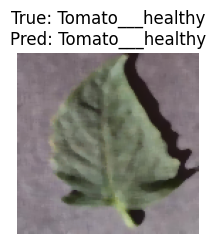

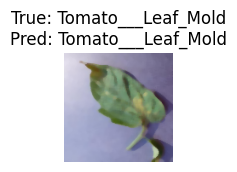

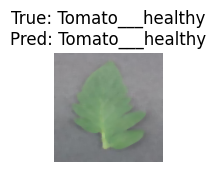

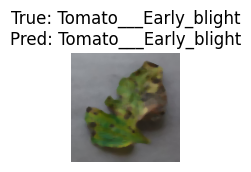

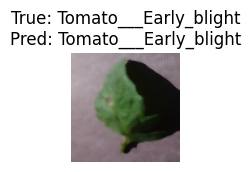

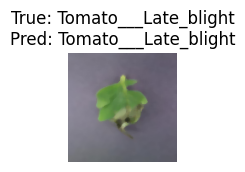

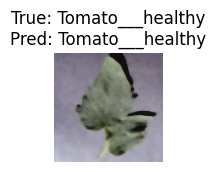

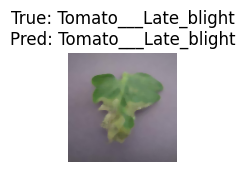

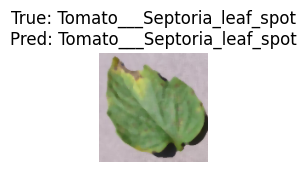

In [10]:
# ===============================
# Affichage prédictions aléatoires
# ===============================
import random
plt.figure(figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = classes[y_test[idx]]
    pred_label = classes[y_pred_classes[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

    plt.show()

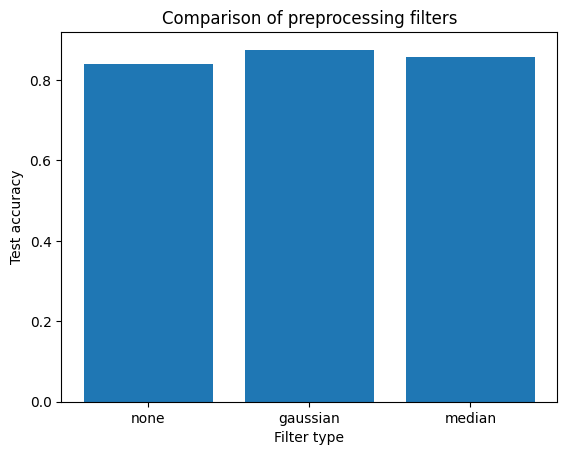


Final results:
none: 0.8409
gaussian: 0.8752
median: 0.8565


In [11]:

# ===============================
# Graphique comparaison finale
# ===============================
plt.figure()
plt.bar(results.keys(), results.values())
plt.xlabel("Filter type")
plt.ylabel("Test accuracy")
plt.title("Comparison of preprocessing filters")
plt.show()

print("\nFinal results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

In [12]:
from tensorflow.keras.preprocessing import image

img_path = r"/home/basma/Plant_Disease/healthy.png"

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
predicted_class = classes[np.argmax(prediction)]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: Tomato___healthy
